# Figure 5, Flow cytometry analysis

In Figure 5, we investigate the effects of lenalidomide and bortezomib on Ikaros, Aiolos, and Helios protein levels by flow cytometry. Here, we'll generate plots for use in figure panels based on analysis results generated in `06-flow-cytometry/`. 

The files involved in this analysis are not stored in HISE, so sources will be retrieved from within this git repository.

## Load packages

dplyr: Dataframe handling functions  
ggplot2: plotting functions  
cowplot: multi-panel plot assembly  

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(cowplot)

In [2]:
out_dir <- "output/figure_5"
if(!dir.exists(out_dir)) { dir.create(out_dir) }

## Load data

Data for these plots is found in `06-flow-cytometry/output/`

In [3]:
treat_pos <- data.frame(
    treatment = c("dmso","bor","bor_len", "len"),
    xpos = 1:4,
    label = c("DMSO", "Bor", "Bor+Len", "Len"),
    color = c("#000000", "#F89D49", "#D0DD4D", "#58C0BC")
)

In [4]:
pop_labels <- c("CD4 Naive", "CD4 CM", "CD4 EM", "CD4 TEMRA", "CD4 Treg",
                "CD8 Naive", "CD8 CM", "CD8 EM", "CD8 TEMRA")

population_labels <- data.frame(
    population = c("t_cd4_naive", "t_cd4_cm", "t_cd4_em", "t_cd4_temra", "t_cd4_treg", 
                   "t_cd8_naive", "t_cd8_cm", "t_cd8_em", "t_cd8_temra"),
    population_label = factor(pop_labels, levels = pop_labels)
)

In [5]:
res <- read.csv("../06-flow-cytometry/output/bor-len_combin_Ikaros-Aiolos-Helios_mfi_stats.csv")

## Barplots

Next, let's plot all of the MFI values as barplots. Each bar will represent the mean MFI across all 5 subjects, with error bars for the standard deviation.

In [6]:
bar_data <- res %>%
  left_join(treat_pos) %>%
  left_join(population_labels) %>%
  mutate(pval_color = ifelse(adjP < 0.05, "black", "gray50")) %>%
  group_by(target) %>%
  mutate(pval_shift = (max(mean_mfi) + max(sd_mfi)) * 0.1)

Joining with `by = join_by(treatment)`
Joining with `by = join_by(population)`


We'll add an asterix to the DMSO results so that a note can be added to specify that the DMSO results are from the comparison between 48 and 24 hr.

In [7]:
bar_data <- bar_data %>%
  mutate(pval_label = round(adjP, 3)) %>%
  mutate(pval_label = ifelse(treatment == "dmso" & !is.na(pval_label),
                             paste0("*",pval_label), pval_label)) %>%
  mutate(pval_label = ifelse(pval_label == "0", "< 0.001", pval_label))

In [8]:
targets <- c("Ikaros", "Aiolos", "Helios")

In [9]:
plot_list <- map(
    targets,
    function(plot_target) {
        bar_data <- bar_data %>%
          filter(target == plot_target)
        
        ggplot() +
          geom_hline(
              data = data.frame(y = 0),
              aes(yintercept = y),
              linewidth = 0.2
          ) +
          geom_errorbar(
              data = bar_data,
              aes(x = xpos,
                  ymin = mean_mfi * 0.9,
                  ymax = mean_mfi + sd_mfi),
              width = 0.2
          )  +
          geom_col(
              data = bar_data,
              aes(x = xpos,
                  y = mean_mfi,
                  fill = color),
              width = 0.6,
              color = "black",
              linewidth = 0.2
          )  +
          geom_text(
              data = bar_data,
              aes(x = xpos,
                  y = mean_mfi + sd_mfi + pval_shift,
                  label = pval_label,
                  color = pval_color)
          ) +
          scale_color_identity() +
          scale_fill_identity() +
          scale_x_continuous(
              "",
              breaks = treat_pos$xpos,
              labels = treat_pos$label
          ) +
          facet_grid(
              rows = vars(population_label),
              cols = vars(timepoint)
          ) +
          theme_bw(base_size = 12) +
          theme(axis.ticks = element_blank(),
                panel.grid.major.x = element_blank(),
                panel.grid.minor.x = element_blank()) +
          ggtitle(plot_target)
    }
)

Warning message:
“Removed 9 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_text()`).”


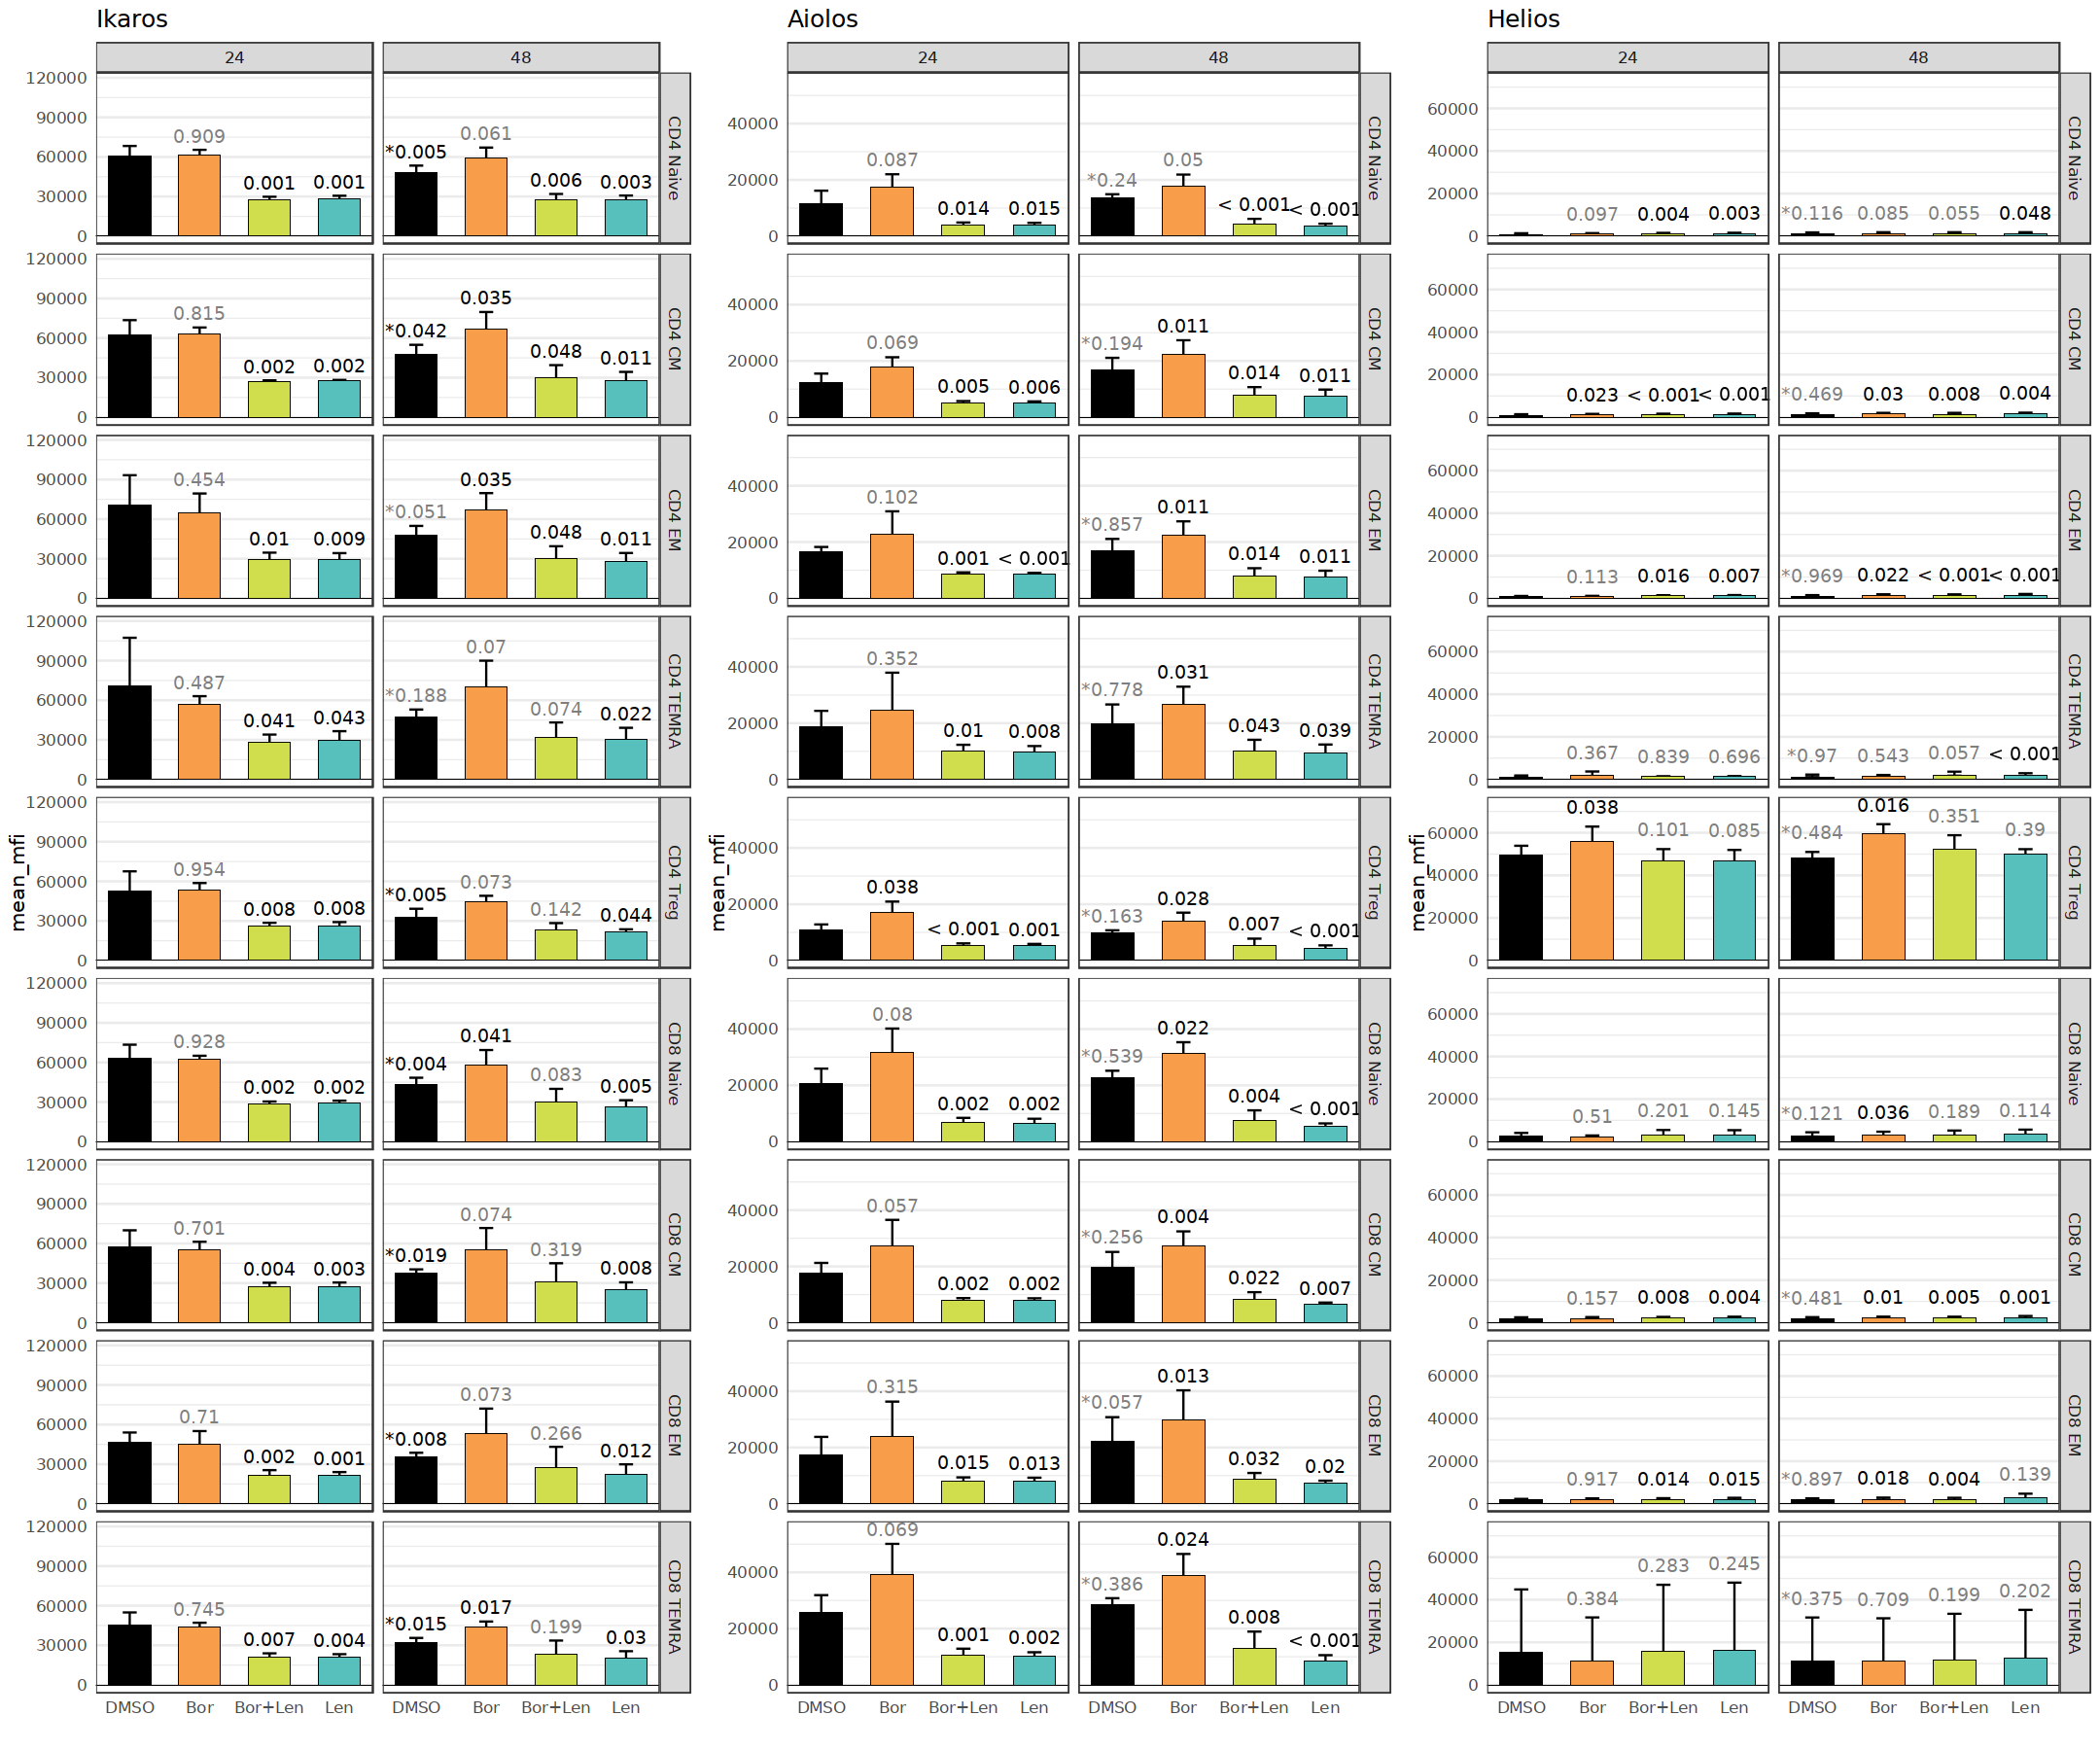

In [10]:
options(repr.plot.width = 18, repr.plot.height = 15)

all_plots <- plot_grid(
    plotlist = plot_list,
    ncol = 3
)

all_plots

In [11]:
ggsave(
    paste0("output/figure_5/bor-len_combin_Ikaros-Aiolos_all_barplots_", Sys.Date(), ".pdf"),
    all_plots,
    width = 18, height = 15
)

This is a lot to show in a main figure. Let's cut it down to a few important populations for the main figure.

In [12]:
fig_types <- c("t_cd4_naive","t_cd4_cm", "t_cd8_naive", "t_cd8_em")

In [13]:
sel_data <- bar_data %>%
  filter(population %in% fig_types)

In [14]:
targets <- c("Ikaros", "Aiolos")

In [15]:
sel_list <- map(
    targets,
    function(plot_target) {
        bar_data <- sel_data %>%
          filter(target == plot_target)
        
        ggplot() +
          geom_hline(
              data = data.frame(y = 0),
              aes(yintercept = y),
              linewidth = 0.2
          ) +
          geom_errorbar(
              data = bar_data,
              aes(x = xpos,
                  ymin = mean_mfi * 0.9,
                  ymax = mean_mfi + sd_mfi),
              width = 0.2
          )  +
          geom_col(
              data = bar_data,
              aes(x = xpos,
                  y = mean_mfi,
                  fill = color),
              width = 0.6,
              color = "black",
              linewidth = 0.2
          )  +
          geom_text(
              data = bar_data,
              aes(x = xpos,
                  y = mean_mfi + sd_mfi + pval_shift,
                  label = pval_label,
                  color = pval_color)
          ) +
          scale_color_identity() +
          scale_fill_identity() +
          scale_x_continuous(
              "",
              breaks = treat_pos$xpos,
              labels = treat_pos$label
          ) +
          facet_grid(
              rows = vars(population_label),
              cols = vars(timepoint)
          ) +
          theme_bw(base_size = 12) +
          theme(axis.ticks = element_blank(),
                panel.grid.major.x = element_blank(),
                panel.grid.minor.x = element_blank()) +
          ggtitle(plot_target)
    }
)

Warning message:
“Removed 4 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_text()`).”


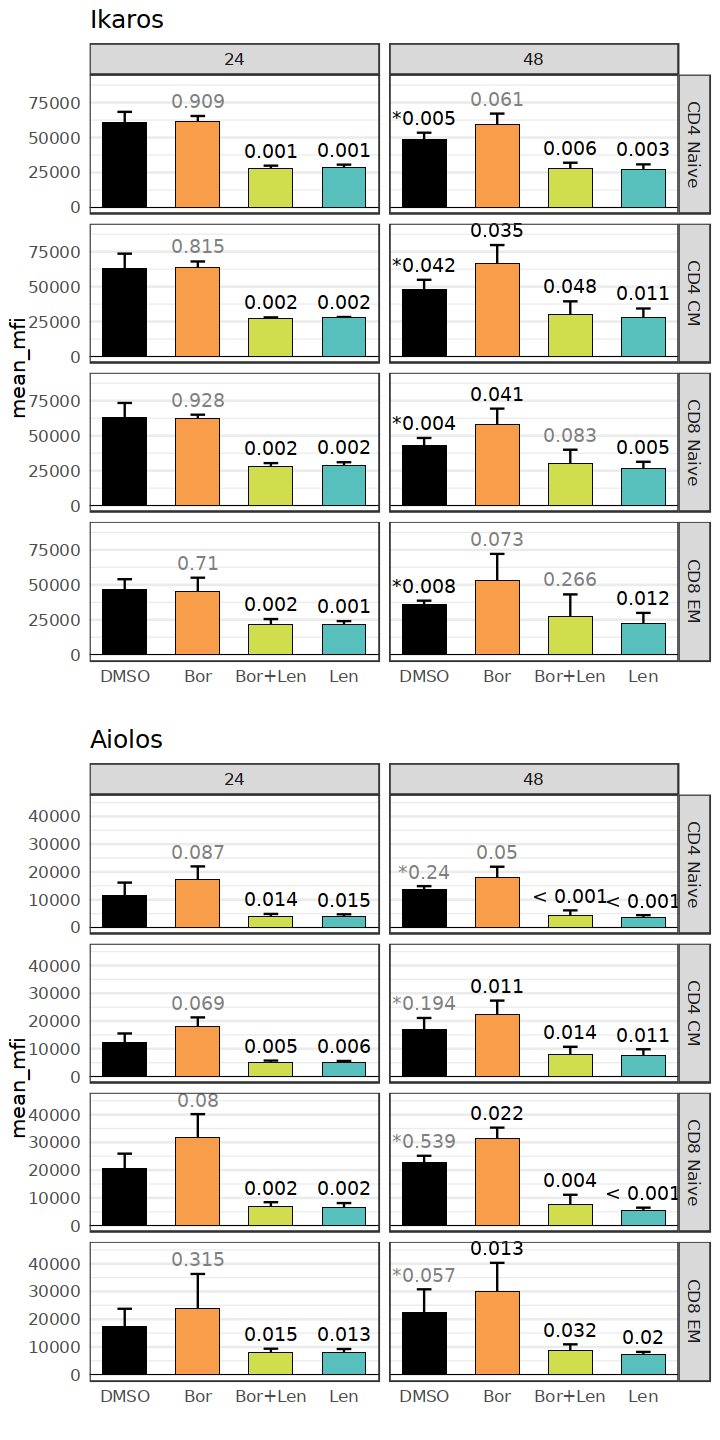

In [16]:
options(repr.plot.width = 6, repr.plot.height = 12)

sel_plots <- plot_grid(
    plotlist = sel_list,
    ncol = 1
)

sel_plots

In [17]:
ggsave(
    paste0("output/figure_5/bor-len_combin_Ikaros-Aiolos_selected_barplots_", Sys.Date(), ".pdf"),
    sel_plots,
    width = 6, height = 12
)

It's difficult to see what's going on in the case of Helios in most non-Treg cells. Let's make this a bit easier to examine by freeing up the linked y-axes.

In [18]:
bar_data <- bar_data %>%
  group_by(target, population) %>%
  mutate(pval_shift = (max(mean_mfi) + max(sd_mfi)) * 0.1)

In [19]:
free_y_list <- map(
    targets,
    function(plot_target) {
        bar_data <- bar_data %>%
          filter(target == plot_target)
        
        ggplot() +
          geom_hline(
              data = data.frame(y = 0),
              aes(yintercept = y),
              linewidth = 0.2
          ) +
          geom_errorbar(
              data = bar_data,
              aes(x = xpos,
                  ymin = mean_mfi * 0.9,
                  ymax = mean_mfi + sd_mfi),
              width = 0.2
          )  +
          geom_col(
              data = bar_data,
              aes(x = xpos,
                  y = mean_mfi,
                  fill = color),
              width = 0.6,
              color = "black",
              linewidth = 0.2
          )  +
          geom_text(
              data = bar_data,
              aes(x = xpos,
                  y = mean_mfi + sd_mfi + pval_shift,
                  label = pval_label,
                  color = pval_color)
          ) +
          scale_color_identity() +
          scale_fill_identity() +
          scale_x_continuous(
              "",
              breaks = treat_pos$xpos,
              labels = treat_pos$label
          ) +
          facet_grid(
              rows = vars(population_label),
              cols = vars(timepoint),
              scales = "free_y"
          ) +
          theme_bw(base_size = 12) +
          theme(axis.ticks = element_blank(),
                panel.grid.major.x = element_blank(),
                panel.grid.minor.x = element_blank()) +
          ggtitle(plot_target)
    }
)

Warning message:
“Removed 9 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 9 rows containing missing values (`geom_text()`).”


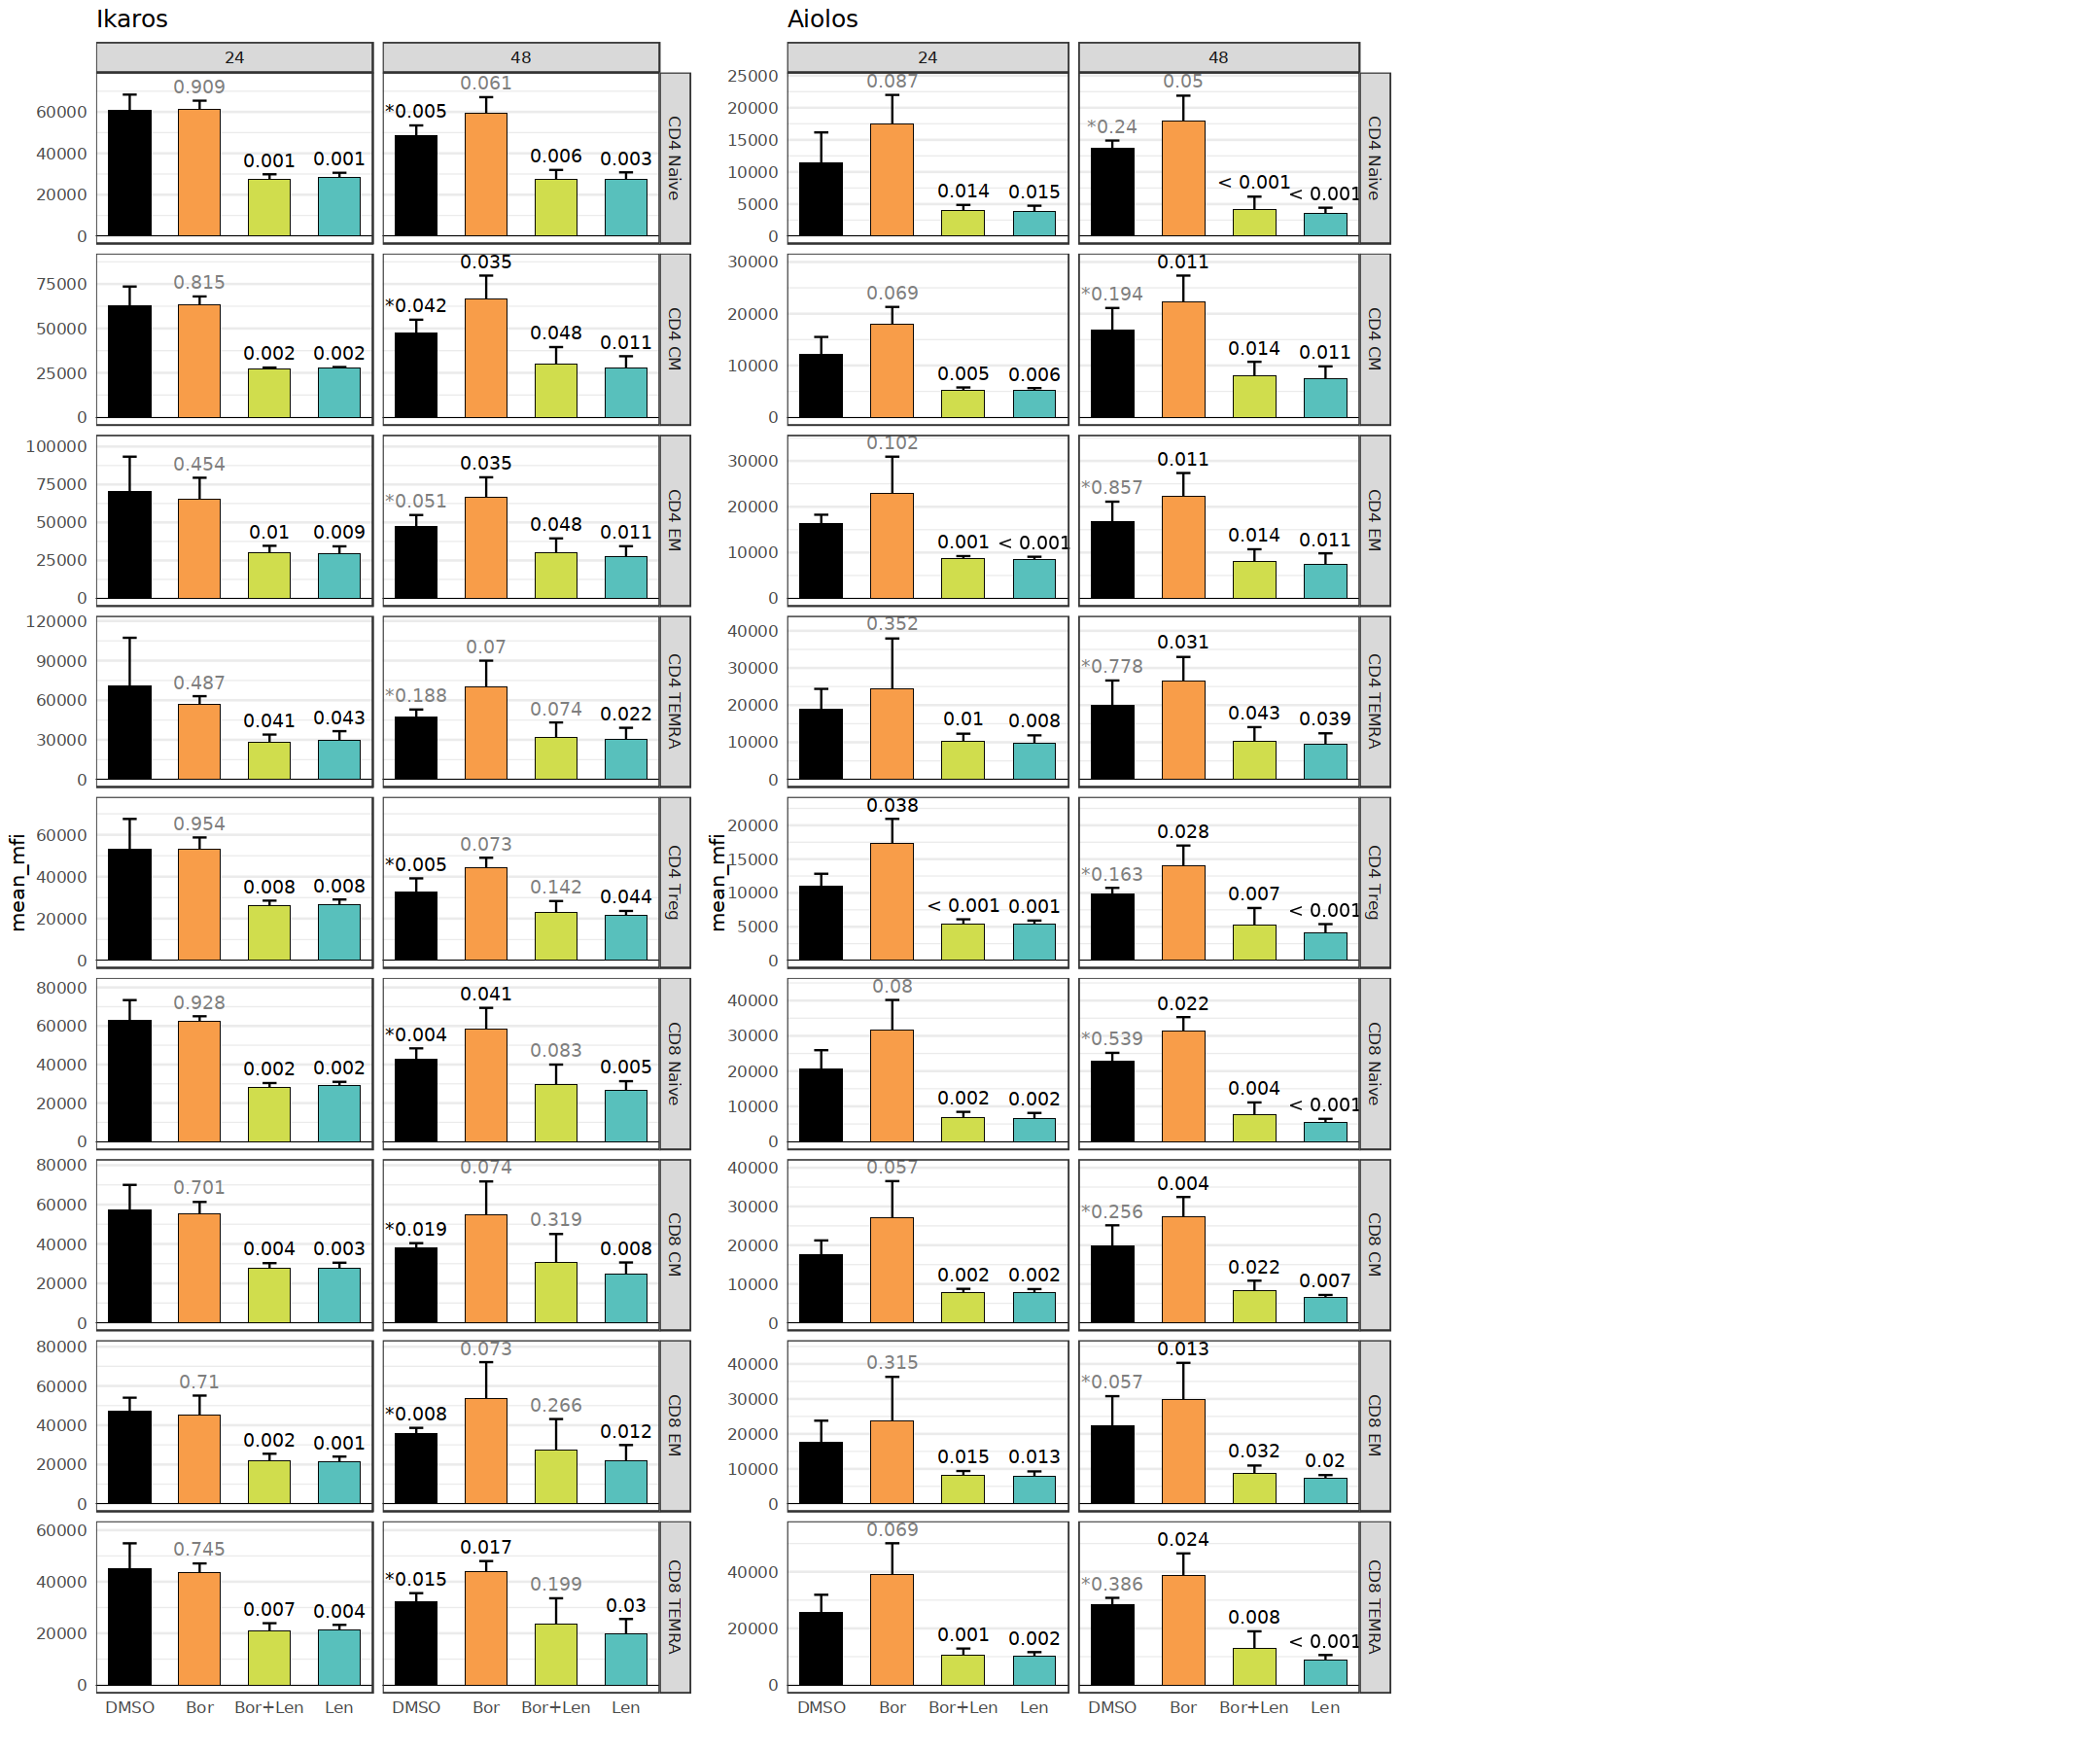

In [20]:
options(repr.plot.width = 18, repr.plot.height = 15)

free_y_plots <- plot_grid(
    plotlist = free_y_list,
    ncol = 3
)

free_y_plots

In [21]:
ggsave(
    paste0("output/figure_5/bor-len_combin_Ikaros-Aiolos_free-y_barplots_", Sys.Date(), ".pdf"),
    free_y_plots,
    width = 18, height = 15
)

In this view, we can see a modest increase in Helios in multiple cell types.

In [22]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.1 ggplot2_3.4.3 dplyr_1.1.3   purrr_1.0.2  

loaded via a namespace (and not attached):
 [1] gtable_0.3.4      jsonlite_1.8.7    compiler_4.3.1    crayon_1.5.2     
 [5] tidyselect_1.2.0  IRdisplay_1.1     textshaping_0.3.6 systemfonts_1.0.4
 [9] scales_1.2.1      uuid_1.1-1        fastmap_1.1.1 